# This notebook corresponds to an e-mission-docs issue: 
# Investigating the high variance counts for certain users and modes in label assist #951 
#### Author: Michael Allen
##### Builds on the work of Wen Zhang, Rahul Kulhalli, Grace Lim, the model by Hannah Lu, and K. Shankari

In this notebook, we fit several random forest models per user and estimate mean and variance of mode share on a hold out set (evaluation set as we've called it) and compare it to the true mode share values in that evaluation set.


### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID
import os

import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/mallen2/alternate_branches/eval-compatible-server/e-mission-server')  

import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())) + "/TRB_label_assist")
import performance_eval
import models
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())) + '/Error_bars/Public_Dashboard/auxiliary_files')


sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())) + '/Error_bars')
import confusion_matrix_handling
import uuid


storage not configured, falling back to sample, default configuration
URL not formatted, defaulting to "Stage_database"
Connecting to database URL localhost


In [2]:
# Set the display options to show more rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns',50)

In [3]:
'''
Function from Grace's code to calculate mode count/distance mean and variance estimates.
inputCM: a dataframe of column normalized counts (so of P(actual|predicted)), columns = sensed, rows = actual modes
predictions: a Series of predicted counts per mode
NMC: number of times to repeat
'''

def multinom_closed_form(inputCM, predictions):
    # get column predictions from inputCM
    column_probabilities = inputCM
    #print("probabilities:\n", column_probabilities)
    mean = {}
    variance = {}
    # calculate mean per mode
    for index, row in column_probabilities.iterrows():
        mean[index] = (row*predictions).sum()
    
    # calculate variance per mode
    for index, row in column_probabilities.iterrows():
        variance[index] =  (predictions*row*(1-row)).sum()
    
    return(pd.Series(mean), pd.Series(variance))

In [4]:
def get_weighted_cm(df, weight_by):
    '''
    df: dataframe with mode_pred and mode_true
    weight_by: string to decide whether to weight by counts or by distance km
    '''
    assert(weight_by in ['distance', 'count'])

    predicted_values = df.mode_pred
    true_values = df.mode_true
    distance_weight = df.distance_km

    if weight_by == 'distance':
        cm = pd.crosstab(true_values, predicted_values, distance_weight, aggfunc='sum')
    elif weight_by == 'count':
        cm = pd.crosstab(true_values, predicted_values)
    
    cm = cm.fillna(0)
    return cm

### Loading data
Only ran this once and then saved the data in elt_with_locations

In [ ]:
all_users = esta.TimeSeries.get_uuid_list()
confirmed_trip_df_map = {}
labeled_trip_df_map = {}
expanded_labeled_trip_df_map = {}
expanded_all_trip_df_map = {}

In [38]:
# loading the data from the docker, cost about 5-6 minutes
for u in all_users:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")

    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_labeled_trip_df_map[u] = esdtq.expand_userinputs(
        labeled_trip_df_map[u])
    expanded_all_trip_df_map[u] = esdtq.expand_userinputs(
        confirmed_trip_df_map[u])

expanded_labeled_trips = pd.concat(expanded_labeled_trip_df_map.values(), ignore_index=True)

In [40]:
elt_with_locations = expanded_labeled_trips.copy()
%store elt_with_locations

Stored 'elt_with_locations' (DataFrame)


In [44]:
ct_with_locations = pd.concat(expanded_all_trip_df_map.values(), ignore_index=True)
%store ct_with_locations

Stored 'ct_with_locations' (DataFrame)


#### Added to save myself time

In [6]:
%store -r elt_with_locations
expanded_labeled_trips = elt_with_locations.copy(); del elt_with_locations
expanded_labeled_trips['distance_km'] = expanded_labeled_trips.distance/1000

# Create a dictionary by user id of trip dataframes
all_users = expanded_labeled_trips.user_id.unique()
expanded_labeled_trip_df_map = {}
for u in all_users:
    expanded_labeled_trip_df_map[u] = expanded_labeled_trips[expanded_labeled_trips["user_id"] == u]

In [7]:
# look at ideal labelers
top_labelers = expanded_labeled_trips.user_id.value_counts()[0:20]
for u in top_labelers.index:
    print(expanded_labeled_trip_df_map[u].mode_confirm.value_counts())

walk            1383
pilot_ebike      935
shared_ride      378
bus              315
bike             136
taxi              39
not_a_trip        23
snowboarding      18
train              5
i_don't know       5
drove_alone        5
gondola            2
free_shuttle       2
air                2
paddle_board       1
Name: mode_confirm, dtype: int64
walk            1006
shared_ride      918
drove_alone      600
pilot_ebike      299
golf_cart         69
bus               48
not_a_trip        43
ski               38
bike              37
train             23
scootershare      22
air               22
taxi              16
free_shuttle      14
boat               3
run                1
Name: mode_confirm, dtype: int64
not_a_trip     1570
walk            367
pilot_ebike     228
drove_alone     121
shared_ride      90
paddleboard       4
bike              1
Name: mode_confirm, dtype: int64
drove_alone    1755
shared_ride     325
walk            215
pilot_ebike      16
not_a_trip        3
bikeshare 

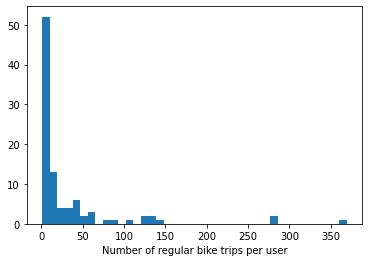

In [8]:
# Regular bike is more rare than ebike in this data, which makes sense since (non stage) users were given ebikes.
bike_counts = []
for u in all_users:
    counts = expanded_labeled_trip_df_map[u].mode_confirm.value_counts()
    if 'bike' in counts.index:
        bike_counts.append(counts['bike'])
plt.hist(bike_counts, bins= 40)
plt.xlabel('Number of regular bike trips per user'); plt.show()

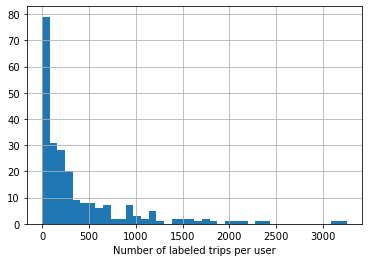

In [9]:
# label_counts is what I use in this notebook to select users to create models for
label_counts = expanded_labeled_trips.user_id.value_counts()
label_counts.hist(bins=40)
plt.xlabel('Number of labeled trips per user'); plt.show()

In [10]:
expanded_labeled_trips.mode_confirm.value_counts()[0:10]

pilot_ebike    22551
shared_ride    22223
drove_alone    21081
walk           14840
not_a_trip      4265
bike            3017
bus             1661
taxi             495
train            219
ski              204
Name: mode_confirm, dtype: int64

### Look at how well our mode share intervals cover the truth in the best case scenario
- lots of trips
- no custom labels

In [10]:
# drop custom labels
# drop modes with less than 100 cases
# split into train_test and evaluation
# train and test model. compare intervals to evaluation data counts
    # make a histogram of var count for each mode

In [11]:
# Set the model to use. See PREDICTORS in performance_eval.py
# 'random forests (coordinates)'
model, model_params = (models.ForestClassifier, {
    'loc_feature': 'coordinates',
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'bootstrap': False,
})

### Fit several models for the best labelers
Check whether esimates are within two variances.

To do so:
- Within k_fold_cross_val_predict:
  - Split data into two sets: train_test and evaluation.
  - train_test is used for cross validation and constructing the confusion matrix.
  - The final model is fit on the entire train_test dataset.


- We assume that the cross validation confusion matrix (sum of results from each test fold) approximates the larger model's confusion matrix.
- evaluation (proxy for unlabeled data) is used to compare our interval estimates with the truth using data that is both:
  - not found in the confusion matrix, and
  - not used to train the model   

In [12]:
def test_models_for_many_users_and_random_states(label_counts, filter_trips, best_labeler=0, worst_labeler=1, n_random_states=1, 
                                                 labeled_unlabeled_proportions = [0.6,0.4], stratify=True):
    '''
    label_counts: Series indexed by user id of label counts in descending order
    filter_trips: (bool) whether to only include standard modes and trips with at least 100 cases
    best_labeler: (int) start of labeler list to analyze
    worst_labeler: (int) end of top labeler list to analyze. This person doesn't get included.
    n_random_states: (int) largest random state to stop at

    Returns:
    all_errors: 
        Dataframe with predicted, expected, and actual counts and distances for the evaluation dataset.
        Also shows number of trips in each mode in each dataset (full, train_test, evaluation).
    '''
    error_df_list = []
    old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
    new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]

    for i, user in enumerate(label_counts.index[best_labeler: worst_labeler]):
        print(f'Testing for user {i + best_labeler}')
        user_df = expanded_labeled_trip_df_map[user]
        # sklearn.model_selection.train_test_split refuses to stratify when there is an nan
        user_df = user_df.loc[user_df.mode_confirm.dropna().index].copy()

        if filter_trips == True:
            # Select only standard modes for which there are at least 100 cases
            filtered_user_df = user_df[user_df.mode_confirm.isin(['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train'])]
            mode_counts = filtered_user_df.mode_confirm.value_counts()
            prominent_modes = mode_counts[mode_counts  >= 100].index.tolist()
            enough_trips = filtered_user_df[filtered_user_df.mode_confirm.isin(prominent_modes)].copy()
        else:
            enough_trips = user_df.copy()
            
        # Format the mode labels the same as the predicted labels
        # the model does this in _clean_data()
        enough_trips['mode_relabeled'] = enough_trips['mode_confirm'].map(confusion_matrix_handling.MODE_MAPPING_DICT)

        for random_state in range(0,n_random_states):
            try:
                results = performance_eval.k_fold_cross_val_predict(model,
                                            model_params,
                                            user_df= enough_trips,
                                            k=5,
                                            random_state= random_state,
                                            min_samples=False,
                                            labeled_unlabeled_proportions = labeled_unlabeled_proportions,
                                            stratify = stratify)
            except:
                print(f'Error in test_models_for_many_users_and_random_states, raised during cross val for user {i}, state {random_state}')
                all_errors = pd.concat(error_df_list)
                all_errors.reset_index(inplace=True)
                all_errors.rename(columns={'index': 'mode'}, inplace=True)

                all_errors['sd from actual for mode count'] = all_errors['var from actual for mode count']*np.sqrt(all_errors['var of eval count'])
            
            try:
                train_test_results = {}
                train_test_results['mode_pred'] = results['mode_pred']
                train_test_results['mode_true'] = results['mode_true']
                train_test_results['duration'] = results['duration']
                train_test_results['distance_meter'] = np.array(results['distance'])
                train_test_results['distance_km'] = train_test_results['distance_meter']/1000

                train_test_results_df = pd.DataFrame(train_test_results)
                evaluation_data = results['validation_data']
                evaluation_data['distance_km'] = evaluation_data.distance/1000

                # Construct confusion matrices for evaluation data and train_test data
                eval_cm = get_weighted_cm(evaluation_data, weight_by='distance')
                train_test_cm = get_weighted_cm(train_test_results_df, 'distance')

                col_normd_cm = train_test_cm/train_test_cm.sum(axis=0)
                prediction_distances = eval_cm.sum(axis=0)  # add rows together to get total predictions

                mean_dists, var_dists = multinom_closed_form(col_normd_cm, prediction_distances)
                true_dists = eval_cm.sum(axis=1) # add columns together to get total true values

                train_test_count_cm = get_weighted_cm(train_test_results_df, 'count')
                eval_count_cm = get_weighted_cm(evaluation_data, 'count')
                col_normd_count_cm = train_test_count_cm/train_test_count_cm.sum(axis=0)
                prediction_counts = evaluation_data.mode_pred.value_counts()
                mean_counts, var_counts = multinom_closed_form(col_normd_count_cm,prediction_counts)
                true_counts = evaluation_data.mode_true.value_counts()

                #only_classic_modes_cm = train_test_count_cm[train_test_count_cm.columns.intersection(new_labels)].loc[train_test_count_cm.index.intersection(new_labels)]

                error= mean_dists - true_dists
                count_error = mean_counts - true_counts

                error_df = pd.DataFrame({
                    "actual dist": true_dists,
                    "predicted dist": prediction_distances,
                    "expected dist": mean_dists,
                    "diff": error,
                    "variance": var_dists,
                    "sd from actual": error.div(np.sqrt(var_dists)),
                    'var from actual': error.div(var_dists),
                    'total trips in mode': enough_trips.mode_relabeled.value_counts(),
                    'train test trip count': train_test_results_df.mode_true.value_counts(),  # number of trips per mode in train test set
                    'evaluation trip count': true_counts,
                    'predicted trip count': prediction_counts,
                    'expected trip count': mean_counts,
                    'var of eval count': var_counts,
                    'var from actual for mode count': count_error.div(var_counts),
                    'dist accuracy on train test': np.diag(train_test_cm).sum()/train_test_cm.sum().sum(),
                    'dist accuracy on evaluation': np.diag(eval_cm).sum()/eval_cm.sum().sum(),
                    'accuracy on train test': np.diag(train_test_count_cm).sum()/train_test_count_cm.sum().sum(),
                    'accuracy on evaluation': np.diag(eval_count_cm).sum()/eval_count_cm.sum().sum(),
                    #'classic_mode_count_accuracy': np.diag(only_classic_modes_cm).sum()/only_classic_modes_cm.sum().sum(),
                    'train test size': len(train_test_results_df),      # total number of trips in train test set
                    'evaluation size': len(evaluation_data)
                })

                error_df['random_state'] = random_state
                error_df['user_id'] = user
                error_df_list.append(error_df)

            except:
                print(f'Error raised post cross val for user {i}, state {random_state}')
                all_errors = pd.concat(error_df_list)
                all_errors.reset_index(inplace=True)
                all_errors.rename(columns={'index': 'mode'}, inplace=True)

                all_errors['sd from actual for mode count'] = all_errors['var from actual for mode count']*np.sqrt(all_errors['var of eval count'])
                return all_errors

    all_errors = pd.concat(error_df_list)
    all_errors.reset_index(inplace=True)
    all_errors.rename(columns={'index': 'mode'}, inplace=True)

    all_errors['sd from actual for mode count'] = all_errors['var from actual for mode count']*np.sqrt(all_errors['var of eval count'])
    
    return all_errors

In [ ]:
# Filtered trips here means select only standard modes for which there are at least 100 cases to fit the model on
# 'walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train'
# Further down in the notebook I allowed the models to fit for any mode.
test_results_filtered_trips_50_tests_user_0 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=0,
    worst_labeler=1,
    n_random_states=1#50
    )

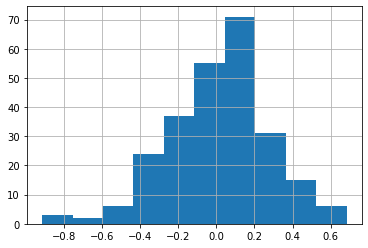

In [75]:
test_results_filtered_trips_50_tests_user_0['var from actual'].hist()

In [ ]:
# how spread out are the variances for people who labeled less?
test_results_filtered_trips_users_29_to_50 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=True,
    best_labeler=29,
    worst_labeler=51,
    n_random_states= 30
    )
# ~45-60 min

In [114]:
merged_test_results_filtered = pd.concat([test_results_filtered_trips_50_tests_user_0, test_results_filtered_trips_users_29_to_50], ignore_index=True)

In [133]:
%store merged_test_results_filtered

Stored 'merged_test_results_filtered' (DataFrame)


In [46]:
%store -r merged_test_results_filtered

In [ ]:
# before runnning this I changed evaluation data size to 0.4 instead of 0.2 in performance_eval > k_fold_cross_val_predict
# My thinking was to save computing power and focus on evaluating when there are a decent number of evaluation trips
test_results_unfiltered_trips = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=0,
    worst_labeler=6,
    n_random_states= 30
    )
# 30m

In [ ]:
test_results_unfiltered_trips_6up = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=6,
    worst_labeler=20,
    n_random_states= 30
    )
#44m

In [66]:
merged_test_results_unfiltered = pd.concat([test_results_unfiltered_trips, test_results_unfiltered_trips_6up], ignore_index=True)

In [ ]:
%store merged_test_results_unfiltered

In [ ]:
test_results_unfiltered_trips_15to30_50rstates = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=15,
    worst_labeler=31,
    n_random_states= 50
    )
#70m

In [ ]:
test_results_unfiltered_trips_80to110_50rstates = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=80,
    worst_labeler=110,
    n_random_states= 50
    )
#64m
#123m

In [24]:
%store test_results_unfiltered_trips_15to30_50rstates

Stored 'test_results_unfiltered_trips_15to30_50rstates' (DataFrame)


In [10]:
%store test_results_unfiltered_trips_80to110_50rstates

Stored 'test_results_unfiltered_trips_80to110_50rstates' (DataFrame)


In [7]:
%store -r test_results_unfiltered_trips_15to30_50rstates
%store -r test_results_unfiltered_trips_80to110_50rstates

In [ ]:
test_results_unfiltered_trips_15to30_50rstates['train test trip count'].value_counts().sort_values(ascending=True).to_dict()

### Plot the number of variances the estimates were from the truth

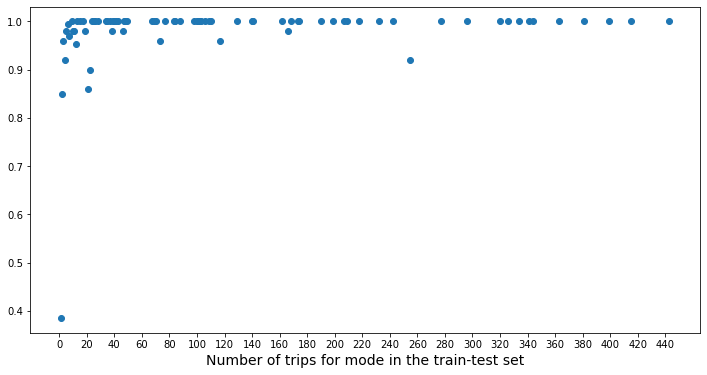

In [10]:
test_results_unfiltered_trips_15to30_50rstates['count_within_2_sd'] = test_results_unfiltered_trips_15to30_50rstates['sd from actual for mode count'] <= 2
test_results_unfiltered_trips_15to30_50rstates['within_2_var'] = test_results_unfiltered_trips_15to30_50rstates['var from actual'] <= 2
test_results_unfiltered_trips_15to30_50rstates['within_3_var'] = test_results_unfiltered_trips_15to30_50rstates['var from actual'] <= 3

grouped = test_results_unfiltered_trips_15to30_50rstates.groupby(['train test trip count'])

trip_count = []
within_2_var_proportion_for_distance = []
within_2_sd_propoortion_for_counts = []
for train_test_trip_count, df in grouped:
    n_within_2_sd = df['count_within_2_sd'].sum()
    n_within_2 = df['within_2_var'].sum()
    n_within_3 = df['within_3_var'].sum()
    trip_count.append(train_test_trip_count)
    within_2_var_proportion_for_distance.append(n_within_2/len(df))
    within_2_sd_propoortion_for_counts.append(n_within_2_sd/len(df))

plt.scatter(trip_count, within_2_var_proportion_for_distance)
plt.xlabel('Number of trips for mode in the train-test set', fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(range(0,450,20))
plt.show()

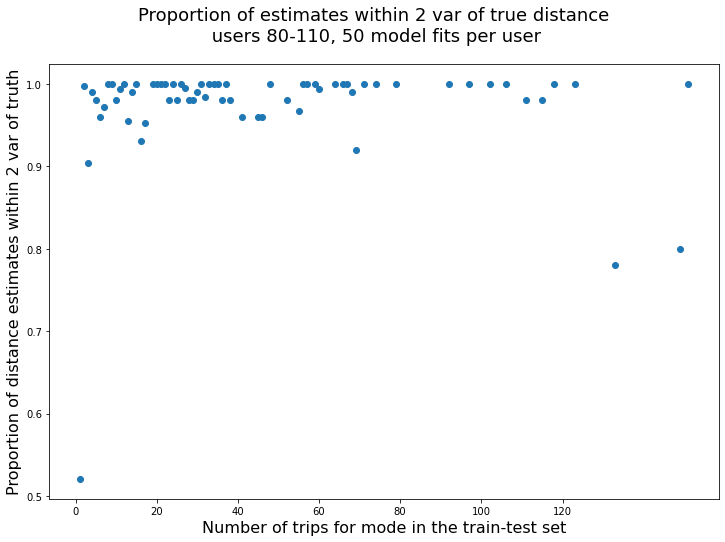

In [21]:
test_results_unfiltered_trips_80to110_50rstates['count_within_2_sd'] = test_results_unfiltered_trips_80to110_50rstates['sd from actual for mode count'] <= 2
test_results_unfiltered_trips_80to110_50rstates['within_2_var'] = test_results_unfiltered_trips_80to110_50rstates['var from actual'] <= 2
test_results_unfiltered_trips_80to110_50rstates['within_3_var'] = test_results_unfiltered_trips_80to110_50rstates['var from actual'] <= 3

grouped = test_results_unfiltered_trips_80to110_50rstates.groupby(['train test trip count'])

trip_count = []
within_2_var_proportion_for_distance = []
within_2_sd_propoortion_for_counts = []
for train_test_trip_count, df in grouped:
    n_within_2_sd = df['count_within_2_sd'].sum()
    n_within_2 = df['within_2_var'].sum()
    n_within_3 = df['within_3_var'].sum()
    trip_count.append(train_test_trip_count)
    within_2_var_proportion_for_distance.append(n_within_2/len(df))
    within_2_sd_propoortion_for_counts.append(n_within_2_sd/len(df))

plt.scatter(trip_count, within_2_var_proportion_for_distance)
plt.xlabel('Number of trips for mode in the train-test set', fontsize = 16)
plt.ylabel('Proportion of distance estimates within 2 var of truth', fontsize=16)
fig = plt.gcf()
fig.set_size_inches(12,8)
fig.suptitle('Proportion of estimates within 2 var of true distance\n users 80-110, 50 model fits per user', fontsize=18)
plt.xticks(range(0,140,20))
plt.show()

In [ ]:
pd.set_option('display.max_rows', 50)#pd.set_option()
print(test_results_unfiltered_trips_15to30_50rstates[['train test trip count', 'sd from actual for mode count']].to_string())

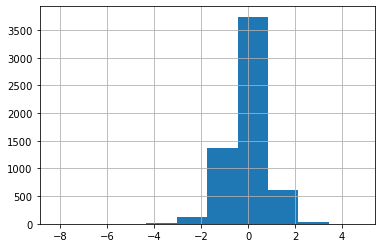

In [30]:
test_results_unfiltered_trips_15to30_50rstates['sd from actual for mode count'].hist()

In [7]:
%store -r merged_test_results_unfiltered

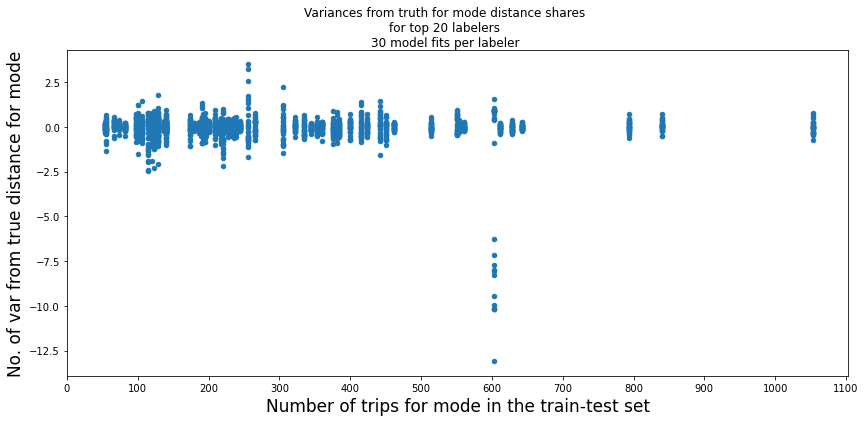

In [100]:
# Looking only at classic modes, what are the variance counts?
# Modes like 'skateboard' would have few examples and high variance counts
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = merged_test_results_unfiltered[merged_test_results_unfiltered['mode'].isin(new_labels)]

# at 46 train test trips, some estimates were > 200 var below the truth
filtered_df[filtered_df['train test trip count']>50].plot('train test trip count', 'var from actual', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,6)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode distance shares\nfor top 20 labelers\n30 model fits per labeler')
plt.xticks(range(0,1200,100)); plt.show()

{'count': 77.0, 'mean': 57.608, 'std': 385.75, 'min': 0.104, '25%': 0.229, '50%': 0.535, '75%': 0.945, 'max': 3246.691}


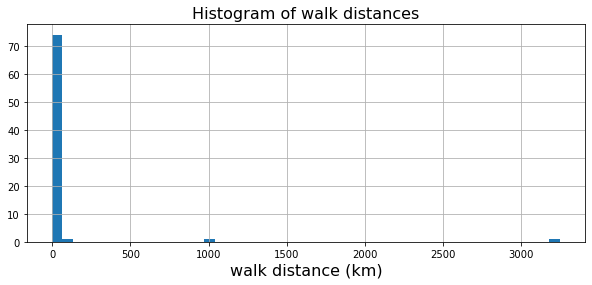

In [36]:
# at 46 train test trips, some estimates were > 200 var below the truth
# It turns out that the person (8461560f-8b4a-4ca6-af2c-b569962dae32) had a 3200 km walk and a 1000 km walk
walk_46 = merged_test_results_unfiltered[merged_test_results_unfiltered['train test trip count'] == 46]

expanded_labeled_trips['distance_km'] = expanded_labeled_trips.distance/1000
user_trips = expanded_labeled_trips[expanded_labeled_trips.user_id == walk_46.iloc[0]['user_id']]
walk_trips = user_trips[user_trips.mode_confirm == 'walk']
print(walk_trips.distance_km.describe().round(3).to_dict())
walk_trips.distance_km.hist(bins=50)
plt.xlabel('walk distance (km)', fontsize=16)
plt.title('Histogram of walk distances', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(10,4)
plt.show()

/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


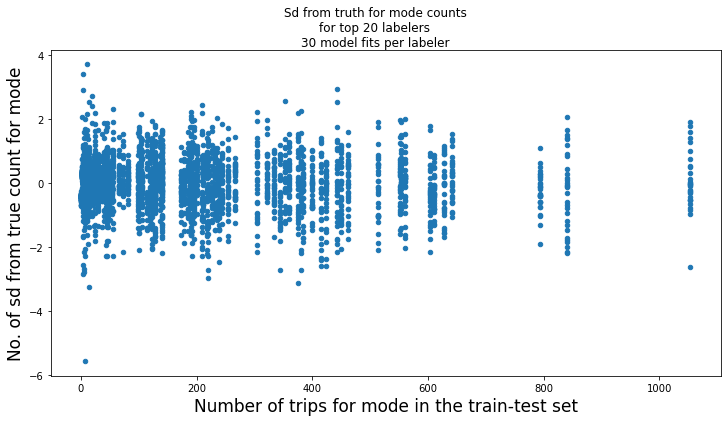

In [37]:
# Looking only at classic modes, what are the variance counts?
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = merged_test_results_unfiltered[merged_test_results_unfiltered['mode'].isin(new_labels)]

filtered_df['sd from actual for counts'] = filtered_df['var from actual for mode count']*np.sqrt(filtered_df['var of eval count'])
filtered_df.plot('train test trip count', 'sd from actual for counts', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of sd from true count for mode', fontsize= 17)
fig.suptitle('Sd from truth for mode counts\nfor top 20 labelers\n30 model fits per labeler')
plt.show()

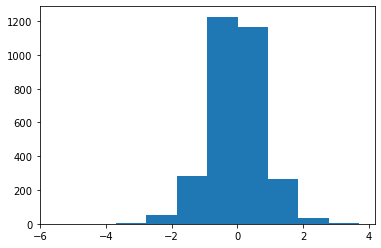

In [38]:
plt.hist(filtered_df['sd from actual for counts']); plt.show()

#### if we train a model with all modes, look only at classic modes, 
and if we know that the unlabeled data comes from the same distribution as the labeled data, then we can estimate uncertainty for counts pretty well, based on the plots below.

Text(0.5, 0.98, 'Histograms of number of standard deviations from the truth\nfor classic mode counts\nand at least 30 training examples per mode')

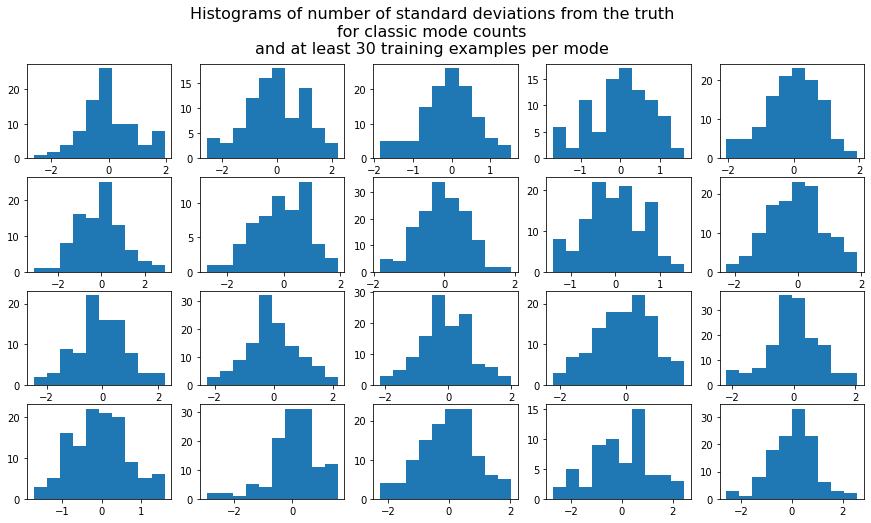

In [53]:
df_grouped_by_user = filtered_df[filtered_df['train test trip count'] > 30].groupby('user_id')
fig, axs = plt.subplots(4,5)
fig.set_size_inches(15,8)
axs = axs.ravel()
i = 0
for user, df in df_grouped_by_user:
    #print(df[['mode','train test trip count']].iloc[0])
    axs[i].hist(df['sd from actual for counts'])
    i+=1
fig.suptitle('Histograms of number of standard deviations from the truth\nfor classic mode counts\nand at least 30 training examples per mode', fontsize = 16)

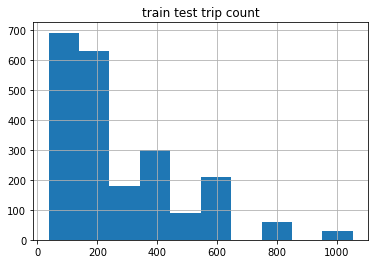

In [55]:
filtered_df[filtered_df['train test trip count'] > 30].hist('train test trip count'); plt.show()

In [31]:
%store merged_test_results_unfiltered

Stored 'merged_test_results_unfiltered' (DataFrame)


In [41]:
two_to_four_100_trips = filtered_df[filtered_df['train test trip count'].between(200,400)].copy()
sorted_df = two_to_four_100_trips.sort_values('var from actual', ascending=False)[['user_id','mode', 'train test trip count', 'evaluation trip count', 'var from actual', 'var from actual for mode count']]
sorted_df.iloc[0:6]

,user_id,mode,train test trip count,evaluation trip count,var from actual,var from actual for mode count
5460,8461560f-8b4a-4ca6-af2c-b569962dae32,"Gas Car, with others",255.0,170.0,3.488019,0.067392
5577,8461560f-8b4a-4ca6-af2c-b569962dae32,"Gas Car, with others",255.0,170.0,3.238867,0.038893
5478,8461560f-8b4a-4ca6-af2c-b569962dae32,"Gas Car, with others",255.0,170.0,2.560785,-0.027166
3893,8fdc9b92-6a67-4a9e-a07d-91df2c5e06f2,Walk,305.0,203.0,2.230685,-0.289858
5550,8461560f-8b4a-4ca6-af2c-b569962dae32,"Gas Car, with others",255.0,170.0,1.745615,0.006977
5568,8461560f-8b4a-4ca6-af2c-b569962dae32,"Gas Car, with others",255.0,170.0,1.586539,-0.011514


{'count': 425.0, 'mean': 50.671, 'std': 262.072, 'min': 0.106, '25%': 1.732, '50%': 8.878, '75%': 27.493, 'max': 3330.94}


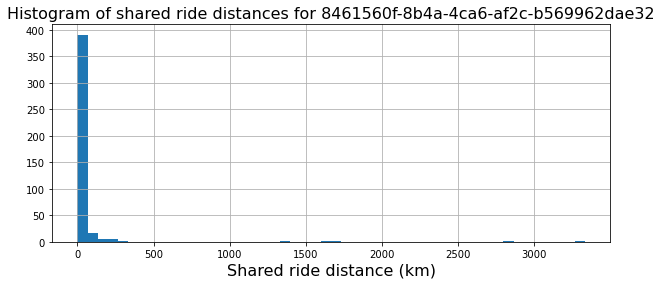

In [42]:
# Extra long shared rides led the distance estimate astray.
expanded_labeled_trips['distance_km'] = expanded_labeled_trips.distance/1000
user_trips = expanded_labeled_trips[expanded_labeled_trips.user_id == sorted_df.iloc[0]['user_id']]
car_trips = user_trips[user_trips.mode_confirm == 'shared_ride']
print(car_trips.distance_km.describe().round(3).to_dict())
car_trips.distance_km.hist(bins=50)
plt.xlabel('Shared ride distance (km)', fontsize=16)
plt.title('Histogram of shared ride distances for 8461560f-8b4a-4ca6-af2c-b569962dae32', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(10,4)
plt.show()

Text(0.5, 0.98, 'Var from truth for mode counts\nfor top 20 labelers\n30 model fits per labeler')

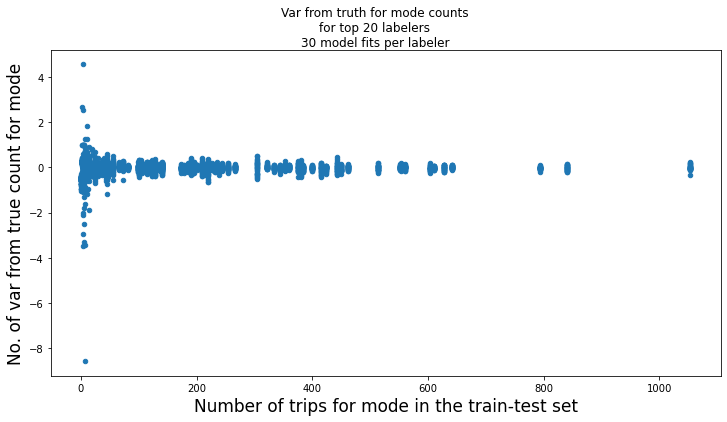

In [44]:
# Looking only at classic modes, are mode counts within a few variances?
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = merged_test_results_unfiltered[merged_test_results_unfiltered['mode'].isin(new_labels)]

filtered_df.plot('train test trip count', 'var from actual for mode count', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true count for mode', fontsize= 17)
fig.suptitle('Var from truth for mode counts\nfor top 20 labelers\n30 model fits per labeler')


In [65]:
lots_of_walks = filtered_df[filtered_df['train test trip count'].between(590,610)].copy()

# this is the user that had the 795 mile walk
lots_of_walks[['user_id','mode', 'train test trip count', 'evaluation trip count', 'var from actual', 'var from actual for mode count']].iloc[0:10]

,user_id,mode,train test trip count,evaluation trip count,var from actual,var from actual for mode count
431,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,0.915413,-0.078399
447,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,1.011547,-0.040819
463,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-0.883389,-0.002160
479,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-7.704426,-0.016067
495,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-8.048663,0.060096
511,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-8.013944,0.057716
527,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-10.195766,-0.104504
543,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,-7.130839,-0.094406
559,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,0.956313,-0.033378
575,bf774cbe-6c30-40b0-a022-278d36a23f19,Walk,603.0,403.0,1.570928,0.016674


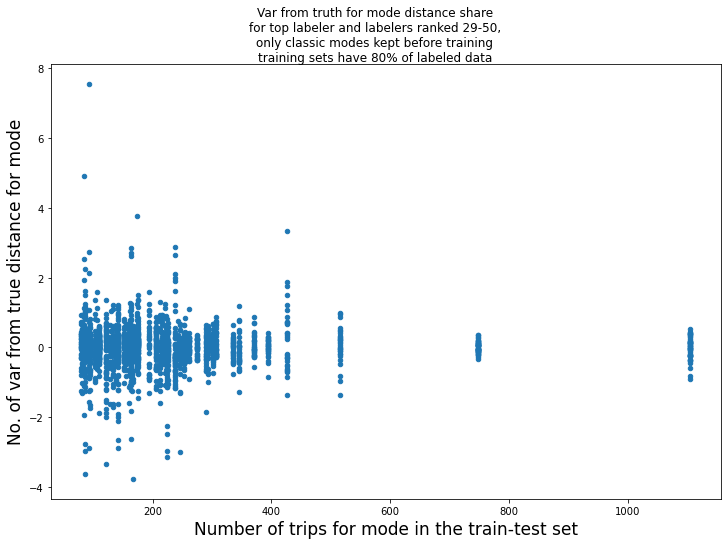

In [59]:
merged_test_results_filtered.plot('train test trip count', 'var from actual', kind='scatter')
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Var from truth for mode distance share\nfor top labeler and labelers ranked 29-50,\nonly classic modes kept before training\ntraining sets have 80% of labeled data')
plt.show()

Text(0, 0.5, 'No. of var from true count for mode')

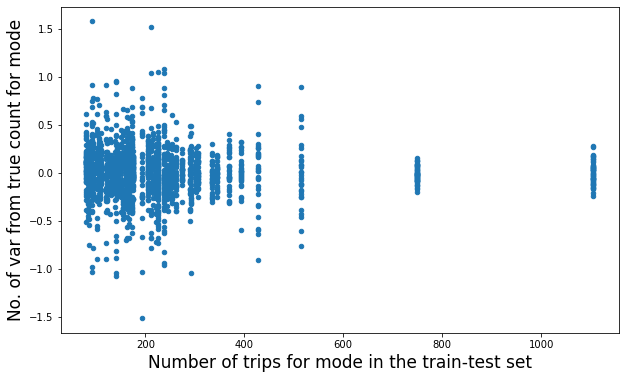

In [58]:
merged_test_results_filtered.plot('train test trip count', 'var from actual for mode count', kind='scatter')
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true count for mode', fontsize= 17)

In [55]:
# just curious how many trips they took
labelers_81_100 = expanded_labeled_trips.user_id.value_counts()[81:100]
for u in labelers_81_100.index:
    print(expanded_labeled_trip_df_map[u].mode_confirm.value_counts())

pilot_ebike    154
shared_ride     76
drove_alone     40
not_a_trip      13
walk            12
paddleboard      2
skateboard       1
Name: mode_confirm, dtype: int64
bus                205
pilot_ebike         41
walk                22
not_a_trip           8
taxi                 7
shared_ride          4
train                3
horse_back ride      2
Name: mode_confirm, dtype: int64
walk           171
shared_ride     53
bike            48
train            6
bus              5
not_a_trip       3
bike_& walk      3
walk_& bike      2
taxi             2
Name: mode_confirm, dtype: int64
pilot_ebike     81
bus             53
walk            47
shared_ride     33
drove_alone     30
not_a_trip      28
car              6
free_shuttle     3
bike             2
Name: mode_confirm, dtype: int64
walk            112
shared_ride      68
drove_alone      55
bike             16
pilot_ebike      11
bikeshare         7
not_a_trip        5
air               2
free_shuttle      2
taxi              1
multi_mod

Text(0.5, 0.98, 'Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler')

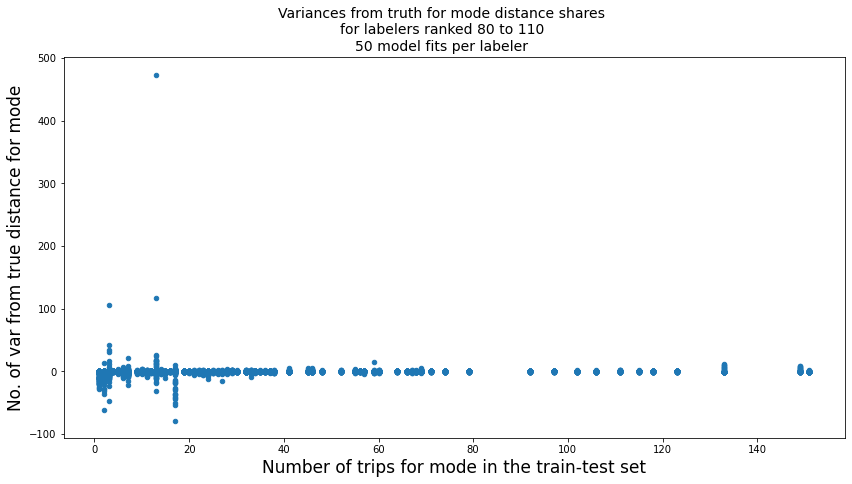

In [148]:
# For users 80-110, Looking only at classic modes, what are the variance counts?
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = test_results_unfiltered_trips_80to110_50rstates[test_results_unfiltered_trips_80to110_50rstates['mode'].isin(new_labels)]

filtered_df.plot('train test trip count', 'var from actual', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler', fontsize=14)

Text(0.5, 0.98, 'Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler')

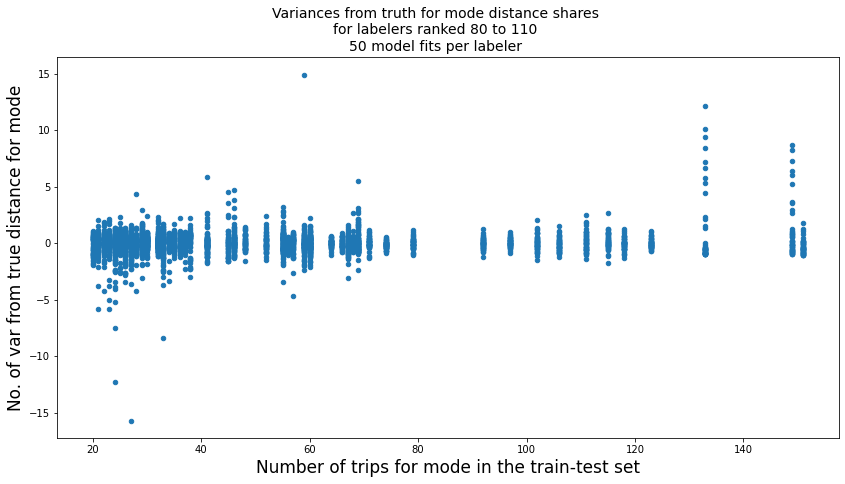

In [149]:
# look for modes with >20 trips
filtered_df = test_results_unfiltered_trips_80to110_50rstates[test_results_unfiltered_trips_80to110_50rstates['mode'].isin(new_labels)]
filtered_df[filtered_df['train test trip count']>=20].plot('train test trip count', 'var from actual', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler', fontsize=14)

Text(0.5, 0.98, 'Variances from truth for mode counts\nfor labelers ranked 80 to 110\n50 model fits per labeler')

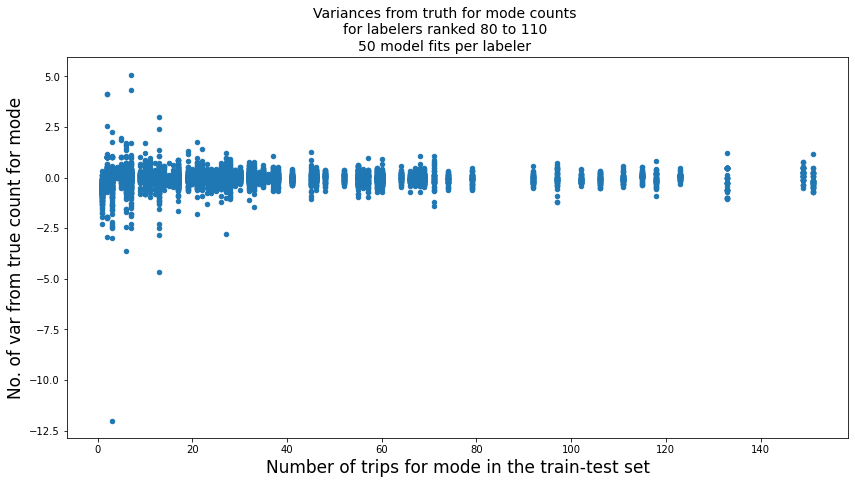

In [107]:
# Look at mode count for users 80-110
filtered_df = test_results_unfiltered_trips_80to110_50rstates[test_results_unfiltered_trips_80to110_50rstates['mode'].isin(new_labels)]
filtered_df.plot('train test trip count', 'var from actual for mode count', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true count for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode counts\nfor labelers ranked 80 to 110\n50 model fits per labeler', fontsize=14)

In [ ]:
# very rough outlier detection
# for each user
# for each mode
# detect outliers
# add boolean column: outlier_mode distance
# hard code 40 km as walk outlier, 50 km as ebike outlier, 500 for drove alone
user_mode_outlier_map = {}
for u in all_users:
    user_df = expanded_labeled_trips[expanded_labeled_trips.user_id==u]
    classic_modes = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
    mode_outlier_map = {}
    for m in user_df.mode_confirm.unique():
        max_mode_dist = user_df[user_df.mode_confirm == m].distance_km.max()
        if m not in classic_modes:
            mode_outlier_map[m] = True
        elif m == 'walk':
            mode_outlier_map[m] = max_mode_dist > 40
        elif m in ['pilot_ebike', 'bike']:
            mode_outlier_map[m] = max_mode_dist > 50
        elif m in ['drove_alone', 'shared_ride']:
            mode_outlier_map[m] = max_mode_dist > 500
        elif m == 'train':
            mode_outlier_map[m] = max_mode_dist > 2000
        elif m == 'bus':
            mode_outlier_map[m] = max_mode_dist > 200

    user_mode_outlier_map[u] = mode_outlier_map
user_mode_outlier_map_relabeled = {}
for u in all_users:
    mode_outlier_map = user_mode_outlier_map[u]
    user_mode_outlier_map_relabeled[u] = {confusion_matrix_handling.MODE_MAPPING_DICT[m]: v for m,v in zip(mode_outlier_map.keys(), mode_outlier_map.values()) if m in confusion_matrix_handling.MODE_MAPPING_DICT.keys()}
outlier_mode_list = []
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]

for _, row in test_results_unfiltered_trips_80to110_50rstates.iterrows():
    u = row['user_id']
    m = row['mode']
    if m not in new_labels: 
        outlier_mode_list.append(True)
    else:
        outlier_mode_list.append(user_mode_outlier_map_relabeled[u][m])
test_results_unfiltered_trips_80to110_50rstates['outlier_mode']= outlier_mode_list

Text(0.5, 0.98, 'Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler')

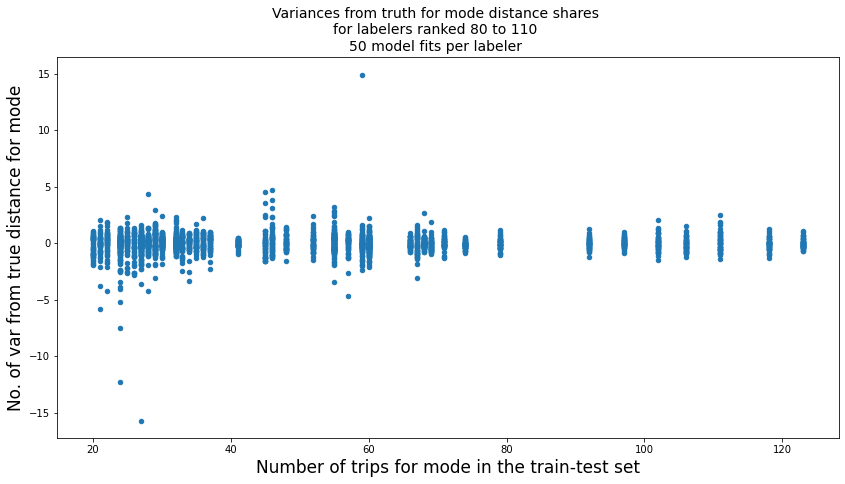

In [157]:
# attempted to remove outliers
filtered_df = test_results_unfiltered_trips_80to110_50rstates[test_results_unfiltered_trips_80to110_50rstates['mode'].isin(new_labels)]
filtered_df_2 = filtered_df[filtered_df['outlier_mode'] == False]
filtered_df_2[filtered_df_2['train test trip count']>=20].plot('train test trip count', 'var from actual', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler', fontsize=14)

Text(0.5, 0.98, 'Variances from truth for mode distance shares\nfor labelers ranked 80 to 110\n50 model fits per labeler')

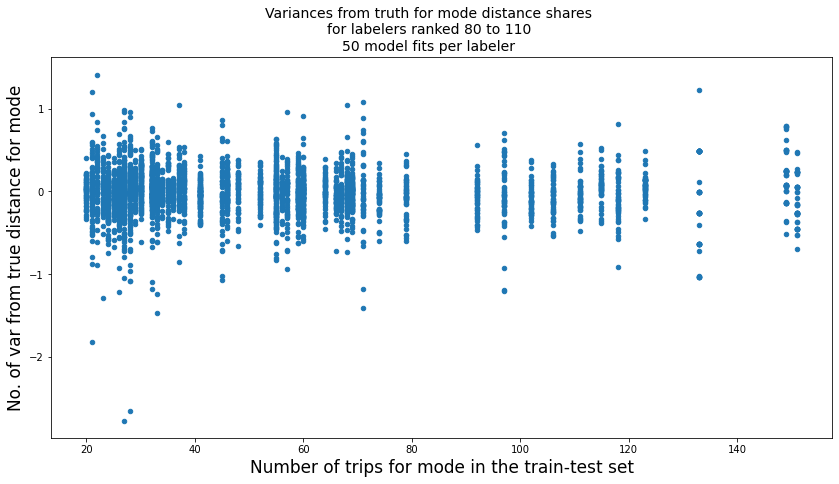

In [68]:
filtered_df[filtered_df['train test trip count']>=20].plot('train test trip count', 'var from actual for mode count', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode counts\nfor labelers ranked 80 to 110\n50 model fits per labeler', fontsize=14)

{'count': 291.0, 'mean': 25.759, 'std': 53.109, 'min': 0.1, '25%': 8.245, '50%': 11.862, '75%': 25.213, 'max': 489.979}
315.3307859719502


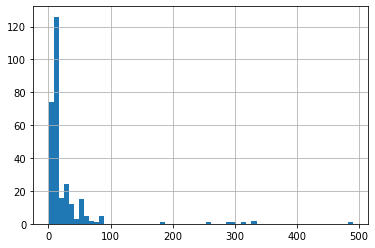

In [111]:
walk_46 = merged_test_results_unfiltered[merged_test_results_unfiltered['train test trip count'] == 46]
user_trips = expanded_labeled_trips[expanded_labeled_trips.user_id == walk_46.iloc[0]['user_id']]


mode_df = user_trips[user_trips.mode_confirm == 'drove_alone']
print(mode_df.distance_km.describe().round(3).to_dict())
print(mode_df.distance_km.quantile(.99))
mode_df.distance_km.hist(bins=60)

### Plot train test dataset size vs var count

In [68]:
def get_train_test_size(df):
    grouped_df = df.groupby(['user_id', 'random_state'])
    totals_for_u_and_rstate = grouped_df.aggregate(np.sum)
    train_test_size_dict = totals_for_u_and_rstate.to_dict()['train test trip count']
    return df.apply(lambda row: train_test_size_dict[(row['user_id'], row['random_state'])], axis = 1)

In [63]:
test_results_unfiltered_trips_15to30_50rstates['train test size'] = test_results_unfiltered_trips_15to30_50rstates.apply(lambda row: train_test_size_dict[(row['user_id'], row['random_state'])], axis = 1)

In [71]:
merged_test_results_unfiltered['train test size'] = get_train_test_size(merged_test_results_unfiltered)

(-10.0, 10.0)

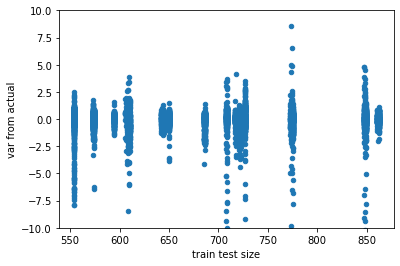

In [67]:
test_results_unfiltered_trips_15to30_50rstates.plot('train test size', 'var from actual', kind='scatter')
plt.ylim(-10,10)

(-10.0, 10.0)

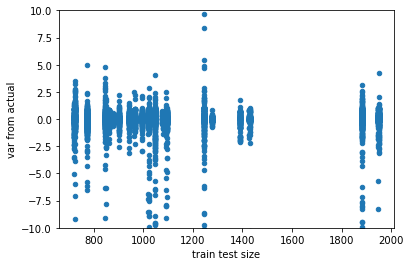

In [72]:
merged_test_results_unfiltered.plot('train test size', 'var from actual', kind='scatter')
plt.ylim(-10,10)

In [87]:
merged_results_unfiltered_with_more = pd.concat([merged_test_results_unfiltered, test_results_unfiltered_trips_15to30_50rstates], ignore_index=True)

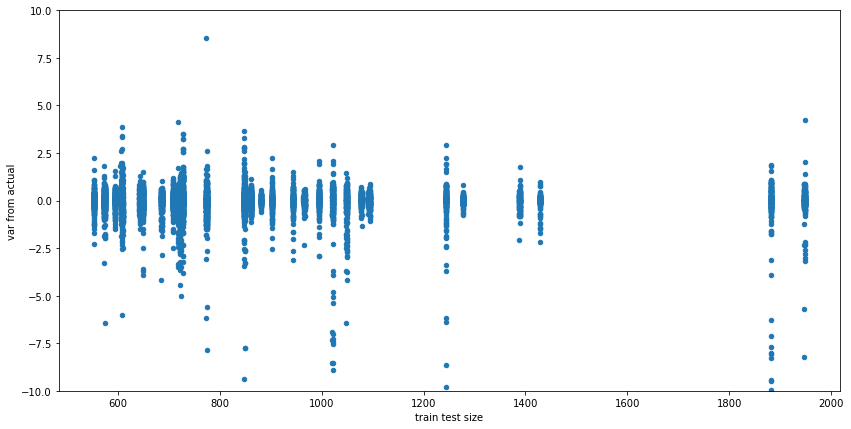

In [113]:
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = merged_results_unfiltered_with_more[merged_results_unfiltered_with_more['mode'].isin(new_labels)]

filtered_df.plot('train test size', 'var from actual', kind='scatter')
plt.ylim(-10,10)
fig = plt.gcf()
fig.set_size_inches(14,7)

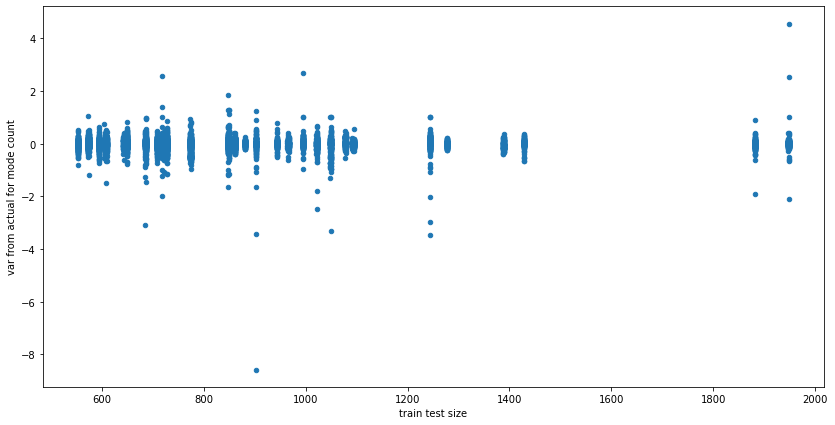

In [114]:
filtered_df.plot('train test size', 'var from actual for mode count', kind='scatter')
fig = plt.gcf()
fig.set_size_inches(14,7)

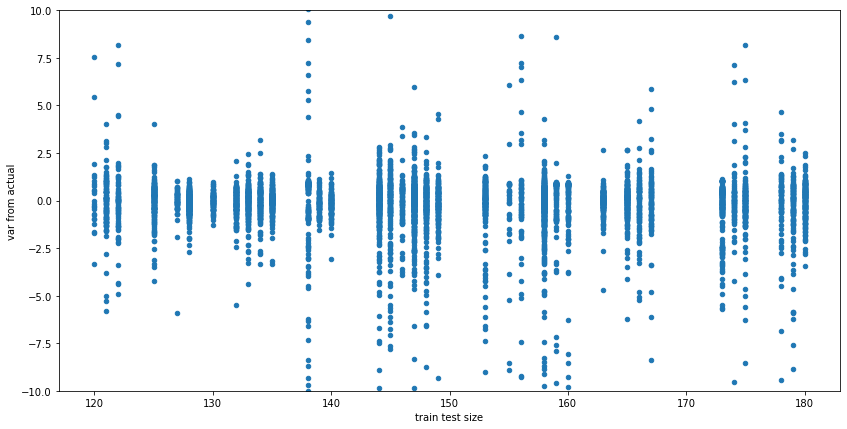

In [22]:
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = test_results_unfiltered_trips_80to110_50rstates[test_results_unfiltered_trips_80to110_50rstates['mode'].isin(new_labels)]

filtered_df.plot('train test size', 'var from actual', kind='scatter')
plt.ylim(-10,10)
fig = plt.gcf()
fig.set_size_inches(14,7)

### What percentage of unlabeled trips fall under the best case?

In [77]:
# for each user, check whether their max mode count is above 40
users_with_40_trips_in_a_mode = []
for u in all_users:
    user_df = expanded_labeled_trip_df_map[u]
    if user_df.mode_confirm.value_counts().max() >= 40 and len(user_df)>100: users_with_40_trips_in_a_mode.append(u)

In [72]:
len(users_with_at_least_30_trips_in_all_modes)

4

In [76]:
mm = user_df.mode_confirm.value_counts()
mm.loc[mm.index.intersection(old_labels)]

walk           58
pilot_ebike     7
bus             3
shared_ride     2
bike            1
Name: mode_confirm, dtype: int64

In [80]:
%store -r ct_with_locations

In [90]:
ct_with_locations.mode_confirm.value_counts(dropna=False)

NaN                                        149041
pilot_ebike                                 22551
shared_ride                                 22223
drove_alone                                 21081
walk                                        14840
                                            ...  
partial_car, partial walk - with others         1
pilot_ebike/car with others                     1
ambulance                                       1
scooter_(non-motorized, non-share)              1
carpool_for lunch                               1
Name: mode_confirm, Length: 132, dtype: int64

In [89]:
expanded_labeled_trips.mode_confirm.value_counts(dropna=False)

pilot_ebike                           22551
shared_ride                           22223
drove_alone                           21081
walk                                  14840
not_a_trip                             4265
                                      ...  
car/walk/car                              1
multiple_modes                            1
time_at work                              1
car-fly                                   1
scooter_(non-motorized, non-share)        1
Name: mode_confirm, Length: 132, dtype: int64

In [84]:
len(ct_with_locations), len(expanded_labeled_trips)

(241123, 92446)

In [113]:
unlabeled_trips = ct_with_locations[ct_with_locations.mode_confirm.isna()]
unlabeled_trips_with_good_models = unlabeled_trips[unlabeled_trips['user_id'].isin(users_with_40_trips_in_a_mode)]
len(unlabeled_trips_with_good_models), len(unlabeled_trips_with_good_models)/len(unlabeled_trips)

(103845, 0.6967545843090156)

In [110]:
len(unlabeled_trips), len(unlabeled_trips)/241123

(149041, 0.6181119179837676)

### Check whether 10s of km makes a difference over km. If we calculated correctly, it should not make a difference

In [14]:
def get_weighted_cm_10km(df, weight_by):
    '''
    df: dataframe with mode_pred and mode_true
    weight_by: string to decide whether to weight by counts or by distance km
    '''
    assert(weight_by in ['distance', 'count'])

    predicted_values = df.mode_pred
    true_values = df.mode_true
    distance_weight = df.distance_10km  # select the 10 km distance column

    if weight_by == 'distance':
        cm = pd.crosstab(true_values, predicted_values, distance_weight, aggfunc='sum')
    elif weight_by == 'count':
        cm = pd.crosstab(true_values, predicted_values)
    
    cm = cm.fillna(0)
    return cm

def test_models_for_many_users_and_random_states_10km(label_counts, filter_trips, best_labeler=0, worst_labeler=1, n_random_states=1, labeled_unlabeled_proportions = [0.6,0.4]):
    '''
    label_counts: Series indexed by user id of label counts in descending order
    filter_trips: (bool) whether to only include standard modes and trips with at least 100 cases
    best_labeler: (int) start of labeler list to analyze
    worst_labeler: (int) end of top labeler list to analyze. This person doesn't get included.
    n_random_states: (int) largest random state to stop at

    Returns:
    all_errors: 
        Dataframe with predicted, expected, and actual counts and distances for the evaluation dataset.
        Also shows number of trips in each mode in each dataset (full, train_test, evaluation).
    '''
    error_df_list = []
    old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
    new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]

    for i, user in enumerate(label_counts.index[best_labeler: worst_labeler]):
        print(f'Testing for user {i + best_labeler}')
        user_df = expanded_labeled_trip_df_map[user]
        # sklearn.model_selection.train_test_split refuses to stratify when there is an nan
        user_df = user_df.loc[user_df.mode_confirm.dropna().index].copy()

        if filter_trips == True:
            # Select only standard modes for which there are at least 100 cases
            filtered_user_df = user_df[user_df.mode_confirm.isin(['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train'])]
            mode_counts = filtered_user_df.mode_confirm.value_counts()
            prominent_modes = mode_counts[mode_counts  >= 100].index.tolist()
            enough_trips = filtered_user_df[filtered_user_df.mode_confirm.isin(prominent_modes)].copy()
        else:
            enough_trips = user_df.copy()
            
        # Format the mode labels the same as the predicted labels
        # the model does this in _clean_data()
        enough_trips['mode_relabeled'] = enough_trips['mode_confirm'].map(confusion_matrix_handling.MODE_MAPPING_DICT)

        for random_state in range(0,n_random_states):
            results = performance_eval.k_fold_cross_val_predict(model,
                                        model_params,
                                        user_df= enough_trips,
                                        k=5,
                                        random_state= random_state,
                                        min_samples=False,
                                        labeled_unlabeled_proportions = labeled_unlabeled_proportions)

            train_test_results = {}
            train_test_results['mode_pred'] = results['mode_pred']
            train_test_results['mode_true'] = results['mode_true']
            train_test_results['duration'] = results['duration']
            train_test_results['distance_meter'] = np.array(results['distance'])
            train_test_results['distance_10km'] = train_test_results['distance_meter']/10000  # edited to chcek whether using 10s of km makes a difference

            train_test_results_df = pd.DataFrame(train_test_results)
            evaluation_data = results['validation_data']
            evaluation_data['distance_10km'] = evaluation_data.distance/10000

            # Construct confusion matrices for evaluation data and train_test data
            eval_cm = get_weighted_cm_10km(evaluation_data, weight_by='distance')
            train_test_cm = get_weighted_cm_10km(train_test_results_df, 'distance')

            col_normd_cm = train_test_cm/train_test_cm.sum(axis=0)
            prediction_distances = eval_cm.sum(axis=0)  # add rows together to get total predictions

            mean_dists, var_dists = multinom_closed_form(col_normd_cm, prediction_distances)
            true_dists = eval_cm.sum(axis=1) # add columns together to get total true values

            train_test_count_cm = get_weighted_cm_10km(train_test_results_df, 'count')
            eval_count_cm = get_weighted_cm_10km(evaluation_data, 'count')
            col_normd_count_cm = train_test_count_cm/train_test_count_cm.sum(axis=0)
            prediction_counts = evaluation_data.mode_pred.value_counts()
            mean_counts, var_counts = multinom_closed_form(col_normd_count_cm,prediction_counts)
            true_counts = evaluation_data.mode_true.value_counts()

            #only_classic_modes_cm = train_test_count_cm[train_test_count_cm.columns.intersection(new_labels)].loc[train_test_count_cm.index.intersection(new_labels)]

            error= mean_dists - true_dists
            count_error = mean_counts - true_counts

            error_df = pd.DataFrame({
                "actual dist": true_dists,
                "predicted dist": prediction_distances,
                "expected dist": mean_dists,
                "diff": error,
                "variance": var_dists,
                "sd from actual": error.div(np.sqrt(var_dists)),
                'var from actual': error.div(var_dists),
                'total trips in mode': enough_trips.mode_relabeled.value_counts(),
                'train test trip count': train_test_results_df.mode_true.value_counts(),  # number of trips per mode in train test set
                'evaluation trip count': true_counts,
                'predicted trip count': prediction_counts,
                'expected trip count': mean_counts,
                'var of eval count': var_counts,
                'var from actual for mode count': count_error.div(var_counts),
                'dist accuracy on train test': np.diag(train_test_cm).sum()/train_test_cm.sum().sum(),
                'dist accuracy on evaluation': np.diag(eval_cm).sum()/eval_cm.sum().sum(),
                'accuracy on train test': np.diag(train_test_count_cm).sum()/train_test_count_cm.sum().sum(),
                'accuracy on evaluation': np.diag(eval_count_cm).sum()/eval_count_cm.sum().sum(),
                #'classic_mode_count_accuracy': np.diag(only_classic_modes_cm).sum()/only_classic_modes_cm.sum().sum(),
                'train test size': len(train_test_results_df),      # total number of trips in train test set
                'evaluation size': len(evaluation_data)
            })

            error_df['random_state'] = random_state
            error_df['user_id'] = user
            error_df_list.append(error_df)

    all_errors = pd.concat(error_df_list)
    all_errors.reset_index(inplace=True)
    all_errors.rename(columns={'index': 'mode'}, inplace=True)

    all_errors['sd from actual for mode count'] = all_errors['var from actual for mode count']*np.sqrt(all_errors['var of eval count'])
    
    return all_errors

In [15]:
user_50 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=50,
    worst_labeler=51,
    n_random_states=1#50
    )

user_50_10km= test_models_for_many_users_and_random_states_10km(
    label_counts, 
    filter_trips=False,
    best_labeler=50,
    worst_labeler=51,
    n_random_states=1#50
    )

Testing for user 50
Dropping user labeled AIR trips in the data set.


/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['mode_pred'] = pred_df_vaild['mode_pred']
/opt/anaconda3/envs/emission-private-eval/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Testing for user 50
Dropping user labeled AIR trips in the data set.


/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['mode_pred'] = pred_df_vaild['mode_pred']


In [29]:
pd.DataFrame([user_50['mode'], user_50_10km['var from actual'], user_50['var from actual']])

,0,1,2,3,4,5
mode,"Gas Car, drove alone","Gas Car, with others",Not a Trip,Regular Bike,Walk,electric_car
var from actual,0.257892,-0.430706,0.372771,0.63007,0.586431,0.0191157
var from actual,0.257892,-0.430706,0.372771,0.63007,0.586431,0.0191157


In [26]:
user_50.columns

Index(['mode', 'actual dist', 'predicted dist', 'expected dist', 'diff',
       'variance', 'sd from actual', 'var from actual', 'total trips in mode',
       'train test trip count', 'evaluation trip count',
       'predicted trip count', 'expected trip count', 'var of eval count',
       'var from actual for mode count', 'dist accuracy on train test',
       'dist accuracy on evaluation', 'accuracy on train test',
       'accuracy on evaluation', 'train test size', 'evaluation size',
       'random_state', 'user_id', 'sd from actual for mode count'],
      dtype='object')

### Check how the models perform with low label proportions and what happens without stratification
Eg if I have 10 labeled drove_alone trips and 200 inferred drove_alone trips, can I use it?

In [22]:
user_0 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=0,
    worst_labeler=1,
    n_random_states=1,#50,
    labeled_unlabeled_proportions= [0.2,0.8],
    stratify=False
    )

Testing for user 0
TESTTEST
Dropping user labeled AIR trips in the data set.


In [23]:
user_0[['mode','actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

,mode,actual dist,expected dist,train test trip count,evaluation trip count,var from actual
0,Air,NaN,NaN,NaN,NaN,NaN
1,Bus,4212.532981,3633.365059,63.0,252.0,-0.304177
2,Free Shuttle,11.588818,NaN,NaN,2.0,NaN
3,"Gas Car, drove alone",31.910128,29.551389,1.0,4.0,-0.080462
4,"Gas Car, with others",4010.439653,4690.817528,76.0,302.0,0.330507
5,Not a Trip,12.839334,33.596988,5.0,18.0,0.623548
6,Pilot ebike,2835.778980,2719.039107,187.0,748.0,-0.117306
7,Regular Bike,317.101483,295.387616,27.0,109.0,-0.078451
8,Taxi/Uber/Lyft,271.252812,541.362426,8.0,31.0,0.530628
9,Train,38.671477,35.847953,1.0,4.0,-0.079654


In [47]:
x = 65
user_x_trips = expanded_labeled_trip_df_map[label_counts.index[x]]
user_x_trips.mode_confirm.value_counts()

shared_ride    212
drove_alone    206
not_a_trip       4
bikeshare        1
Name: mode_confirm, dtype: int64

In [28]:
user_x = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=x,
    worst_labeler=x+1,
    n_random_states=1,#50,
    labeled_unlabeled_proportions= [0.05,0.95],
    stratify=False
    )
user_x[['mode','actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

Testing for user 40
TESTTEST
Dropping user labeled AIR trips in the data set.


In [29]:
user_x[['mode','actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

,mode,actual dist,expected dist,train test trip count,evaluation trip count,var from actual
0,Bus,10.897883,NaN,NaN,3,NaN
1,"Gas Car, drove alone",579.508500,611.177524,10.0,197,0.102257
2,"Gas Car, with others",1998.948766,1681.729776,19.0,365,-0.560569
3,Not a Trip,3.619298,NaN,NaN,1,NaN
4,Pilot ebike,267.682743,569.554334,5.0,95,0.696213
5,Walk,1.804443,NaN,NaN,4,NaN


In [ ]:
x = 50
users_50_plus = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=x,
    worst_labeler=x+27,
    n_random_states=30,#50,
    labeled_unlabeled_proportions= [0.20,0.80],
    stratify=False
    )
users_50_plus[['mode','actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

In [ ]:
x = 77
users_77to79 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=x,
    worst_labeler=x+3,
    n_random_states=30,#50,
    labeled_unlabeled_proportions= [0.20,0.80],
    stratify=False
    )

In [15]:
users_79 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=79,
    worst_labeler=80,
    n_random_states=3,#50,
    labeled_unlabeled_proportions= [0.20,0.80],
    stratify=False
    )

Testing for user 79
Dropping user labeled AIR trips in the data set.
no strat


/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['mode_pred'] = pred_df_vaild['mode_pred']


Dropping user labeled AIR trips in the data set.
no strat


/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['mode_pred'] = pred_df_vaild['mode_pred']


Dropping user labeled AIR trips in the data set.
no strat
Error raised during cross val for user 0, state 2


In [31]:
labeled_unlabeled_proportions = [0.2,0.8]
user = label_counts.index[80:81][0]
user_df = expanded_labeled_trip_df_map[user]
results = performance_eval.k_fold_cross_val_predict(model,
                            model_params,
                            user_df= user_df,
                            k=5,
                            random_state= 2,
                            min_samples=False,
                            labeled_unlabeled_proportions = labeled_unlabeled_proportions,
                            stratify = False)

Dropping user labeled AIR trips in the data set.
no strat


/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data['mode_pred'] = pred_df_vaild['mode_pred']


In [17]:
for i, user in enumerate(label_counts.index[79: 80]):
    print(f'Testing for user {i + 79}')
    print(user)

Testing for user 79
a231adde-d867-4bef-9509-2b32bc254ac8


In [21]:
user[0]

UUID('a231adde-d867-4bef-9509-2b32bc254ac8')

In [23]:
users_50_to_79_no_stratify = users_50_plus.copy()
%store users_50_to_79_no_stratify

Stored 'users_50_to_79_no_stratify' (DataFrame)


In [ ]:
x = 66
users_66to76 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=x,
    worst_labeler=x+11,
    n_random_states=30,#50,
    labeled_unlabeled_proportions= [0.20,0.80],
    stratify=False
    )

In [38]:
users_50_plus[['mode','actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

,mode,actual dist,expected dist,train test trip count,evaluation trip count,var from actual
0,"Gas Car, drove alone",734.649348,1707.652519,4.0,72,0.924600
1,"Gas Car, with others",4170.328227,2539.529371,11.0,205,-1.360752
2,Not a Trip,1.664941,NaN,NaN,2,NaN
3,Regular Bike,118.284024,585.276719,2.0,32,0.906447
4,Walk,155.003034,385.918606,10.0,199,0.673556
5,electric_car,38.447641,NaN,NaN,10,NaN


In [13]:
user_65 = test_models_for_many_users_and_random_states(
    label_counts, 
    filter_trips=False,
    best_labeler=65,
    worst_labeler=66,
    n_random_states=1,#50,
    labeled_unlabeled_proportions= [0.2,0.8],
    stratify=False
    )

# plot for a few users and random states. repeat without stratifying.
# then you're done.

Testing for user 65
Dropping user labeled AIR trips in the data set.
no strat


/Users/mallen2/alternate_branches/Wen_label_assist_evaluation_code/downstream_matrices_evaluations/TRB_label_assist/performance_eval.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  'mode_initial': mode_initial, # Saving the initial mode name, for connecting with the evaluation methods.


In [14]:
user_65[['mode', 'actual dist', 'expected dist','train test trip count', 'evaluation trip count', 'var from actual']]

,mode,actual dist,expected dist,train test trip count,evaluation trip count,var from actual
0,Bikeshare,NaN,NaN,NaN,NaN,NaN
1,"Gas Car, drove alone",1139.643023,640.507519,37.0,169.0,-0.985443
2,"Gas Car, with others",2135.438983,2587.591026,46.0,166.0,0.839186
3,Not a Trip,3.348156,50.331616,1.0,3.0,0.951654


In [32]:
%store -r users_50_to_79_no_stratify

In [33]:
len(users_50_to_79_no_stratify.user_id.unique())

27

In [16]:
users_50_to_76_no_stratify = users_50_to_79_no_stratify.copy() # fixing mislabeling
len(users_50_to_79_no_stratify.user_id.unique())

27

Text(0.5, 0.98, 'Variances from truth for mode distance shares,\n for modes with at least 10 labeled')

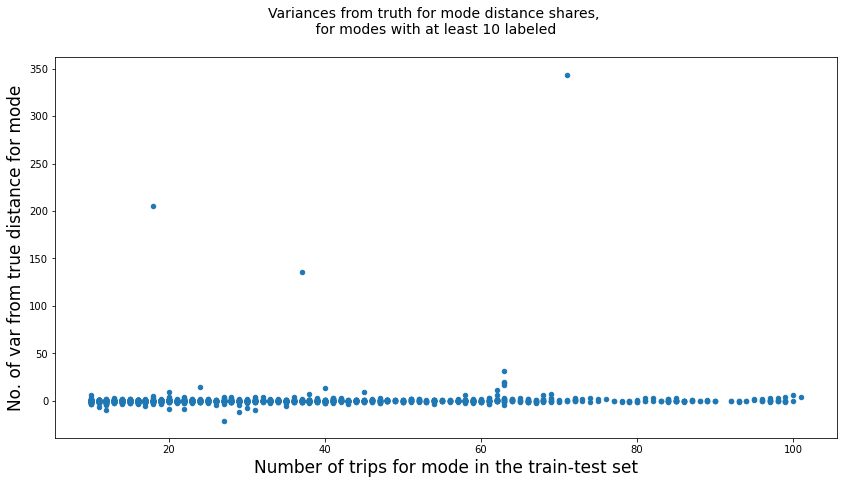

In [55]:
# Looking only at classic modes, what are the variance counts?
# Modes like 'skateboard' would have few examples and high variance counts
old_labels = ['walk','pilot_ebike','shared_ride', 'bus', 'bike', 'drove_alone','train']
new_labels = [confusion_matrix_handling.MODE_MAPPING_DICT[old] for old in old_labels]
filtered_df = users_50_to_79_no_stratify[users_50_to_79_no_stratify['mode'].isin(new_labels)]

filtered_df[filtered_df['train test trip count']>=10].plot('train test trip count', 'var from actual', kind='scatter')

fig = plt.gcf()
fig.set_size_inches(14,7)
plt.xlabel('Number of trips for mode in the train-test set', fontsize= 17)
plt.ylabel('No. of var from true distance for mode', fontsize= 17)
fig.suptitle('Variances from truth for mode distance shares,\n for modes with at least 10 labeled', fontsize=14)

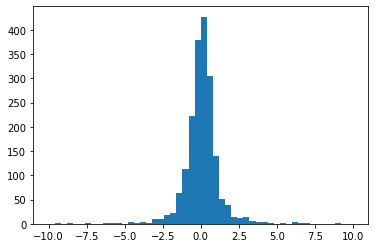

In [51]:
plt.hist(filtered_df[filtered_df['train test trip count']>=10]['var from actual'], bins=50, range=[-10,10]); plt.show()

In [54]:
filtered_df[filtered_df['train test trip count']>=10]['var from actual'].abs().quantile(0.95)#.describe()

2.4152280522776124

In [50]:
filtered_df[filtered_df['train test trip count']>=10]['var from actual'].min()

-20.62004695083984

In [39]:
filtered_df[filtered_df['train test trip count']>=10]

,mode,actual dist,predicted dist,expected dist,diff,variance,sd from actual,var from actual,total trips in mode,train test trip count,evaluation trip count,predicted trip count,expected trip count,var of eval count,var from actual for mode count,dist accuracy on train test,dist accuracy on evaluation,accuracy on train test,accuracy on evaluation,train test size,evaluation size,random_state,user_id,sd from actual for mode count
0,"Gas Car, drove alone",713.947322,106.672487,157.925904,-556.021418,151.704163,-45.143245,-3.665169,76.0,12.0,64.0,29.0,42.967168,34.621616,-0.607506,0.722815,0.726869,0.623853,0.333333,109,438,0,73c7bf7e-2552-4a6d-b211-62190d2322e2,-3.574572
1,"Gas Car, with others",3406.834014,3741.664392,3774.893539,368.059525,362.646510,19.327528,1.014926,216.0,46.0,170.0,177.0,168.236833,76.110550,-0.023166,0.722815,0.726869,0.623853,0.333333,109,438,0,73c7bf7e-2552-4a6d-b211-62190d2322e2,-0.202102
4,Walk,131.206996,267.354314,203.874254,72.667258,102.813316,7.166615,0.706788,210.0,39.0,170.0,206.0,180.236662,49.743614,0.205788,0.722815,0.726869,0.623853,0.333333,109,438,0,73c7bf7e-2552-4a6d-b211-62190d2322e2,1.451409
6,"Gas Car, drove alone",479.571437,211.791914,1082.577748,603.006311,806.725903,21.230433,0.747474,76.0,11.0,65.0,33.0,50.078765,41.052123,-0.363470,0.664024,0.818722,0.284404,0.406393,109,438,1,73c7bf7e-2552-4a6d-b211-62190d2322e2,-2.328826
7,"Gas Car, with others",3696.736885,4014.894187,3103.401295,-593.335589,853.823861,-20.305620,-0.694916,216.0,40.0,176.0,212.0,180.231035,68.902512,0.061406,0.664024,0.818722,0.284404,0.406393,109,438,1,73c7bf7e-2552-4a6d-b211-62190d2322e2,0.509717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591,Pilot ebike,831.883090,886.816616,874.585226,42.702136,12.062689,12.294972,3.540018,310.0,61.0,249.0,260.0,247.812500,11.616211,-0.102228,0.986208,0.005451,0.953125,0.007663,64,261,25,4b89612d-7f1f-4b36-8635-c2bc48bd7993,-0.348419
5595,Pilot ebike,874.196808,933.132867,929.768955,55.572147,3.351785,30.354219,16.579864,310.0,63.0,247.0,261.0,256.857143,4.077098,2.417686,0.992663,0.004113,0.968750,0.003831,64,261,26,4b89612d-7f1f-4b36-8635-c2bc48bd7993,4.881750
5599,Pilot ebike,882.375775,918.331895,830.024326,-52.351448,79.815839,-5.859818,-0.655903,310.0,63.0,247.0,261.0,256.921875,4.014404,2.471568,0.903839,0.004179,0.984375,0.003831,64,261,27,4b89612d-7f1f-4b36-8635-c2bc48bd7993,4.952029
5603,Pilot ebike,915.633122,964.993457,933.775021,18.141899,30.208491,3.300793,0.600556,310.0,62.0,248.0,259.0,247.046154,11.402130,-0.083655,0.019483,0.046906,0.015385,0.034615,65,260,28,4b89612d-7f1f-4b36-8635-c2bc48bd7993,-0.282478


In [19]:
filtered_df[filtered_df['train test trip count']>=10]['var from actual'].describe()

count    1890.000000
mean        0.483171
std         9.865596
min       -20.620047
25%        -0.414373
50%         0.078012
75%         0.550161
max       343.663190
Name: var from actual, dtype: float64

In [23]:
filtered_df[(filtered_df['var from actual'] > 300) & (filtered_df['train test trip count']>=10)]

,mode,actual dist,predicted dist,expected dist,diff,variance,sd from actual,var from actual,total trips in mode,train test trip count,evaluation trip count,predicted trip count,expected trip count,var of eval count,var from actual for mode count,dist accuracy on train test,dist accuracy on evaluation,accuracy on train test,accuracy on evaluation,train test size,evaluation size,random_state,user_id,sd from actual for mode count
5124,Pilot ebike,763.491563,917.05319,916.607433,153.115869,0.44554,229.391125,343.66319,340.0,71.0,269.0,292.0,287.944444,3.999228,4.737025,0.999514,0.089437,0.986111,0.013699,72,292,13,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,9.473136


In [27]:
filtered_df[filtered_df['train test trip count']>=10][['mode', 'evaluation trip count', 'expected trip count', 'train test trip count', 'var from actual', 'sd from actual for mode count']]

,mode,evaluation trip count,expected trip count,train test trip count,var from actual,sd from actual for mode count
0,"Gas Car, drove alone",64.0,42.967168,12.0,-3.665169,-3.574572
1,"Gas Car, with others",170.0,168.236833,46.0,1.014926,-0.202102
4,Walk,170.0,180.236662,39.0,0.706788,1.451409
6,"Gas Car, drove alone",65.0,50.078765,11.0,0.747474,-2.328826
7,"Gas Car, with others",176.0,180.231035,40.0,-0.694916,0.509717
...,...,...,...,...,...,...
5591,Pilot ebike,249.0,247.812500,61.0,3.540018,-0.348419
5595,Pilot ebike,247.0,256.857143,63.0,16.579864,4.881750
5599,Pilot ebike,247.0,256.921875,63.0,-0.655903,4.952029
5603,Pilot ebike,248.0,247.046154,62.0,0.600556,-0.282478


In [31]:
filtered_df[filtered_df['train test trip count']>=10]['sd from actual for mode count'].quantile(0.90) #.describe()

3.1699064498210987

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  4.,  3.,  4.,  8.,
        17., 19., 38., 25., 19.,  6.,  3.]),
 array([-6.10352041, -5.71210116, -5.3206819 , -4.92926265, -4.53784339,
        -4.14642414, -3.75500489, -3.36358563, -2.97216638, -2.58074712,
        -2.18932787, -1.79790861, -1.40648936, -1.01507011, -0.62365085,
        -0.2322316 ,  0.15918766,  0.55060691,  0.94202617,  1.33344542,
         1.72486468]),
 <a list of 20 Patch objects>)

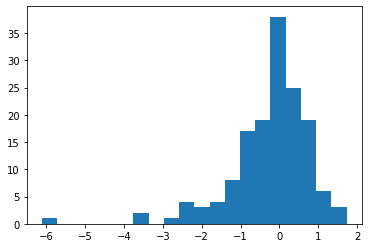

In [45]:
conditions = (filtered_df['var from actual'] < 300) & (filtered_df['train test trip count'].between(10,20)) & (filtered_df['mode'] == 'Gas Car, drove alone')
plt.hist(filtered_df[conditions]['var from actual'], bins=20)

In [48]:
filtered_df[conditions]['var from actual'].abs().quantile(0.9) 

1.5892593573971723

In [50]:
# Set the display options to show more rows and columns
pd.set_option('display.max_rows', 160)


In [54]:
conditions = (filtered_df['var from actual'] < 300) & (filtered_df['train test trip count'].between(10,20)) & (filtered_df['mode'] == 'Gas Car, with others')
filtered_df[conditions][['evaluation trip count', 'train test trip count', 'var from actual', 'sd from actual for mode count']]

,evaluation trip count,train test trip count,var from actual,sd from actual for mode count
321,21.0,10.0,2.036997,3.070423
519,21.0,10.0,-0.687878,4.578657
537,19.0,12.0,1.287877,4.226148
962,66.0,15.0,-0.281314,-0.503810
968,67.0,14.0,-0.433876,-1.295655
974,68.0,13.0,-1.298119,-3.955342
980,67.0,14.0,0.131642,-0.119347
986,61.0,20.0,0.669941,2.091728
992,65.0,16.0,-0.494404,-1.061226
998,63.0,18.0,0.308015,0.930563
